### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

import shap

Взял этот набор данных:

https://archive.ics.uci.edu/ml/datasets/Adult

In [41]:
df = pd.read_csv("adult.data", header=None)

In [42]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       32561 non-null  int64 
 1   1       32561 non-null  object
 2   2       32561 non-null  int64 
 3   3       32561 non-null  object
 4   4       32561 non-null  int64 
 5   5       32561 non-null  object
 6   6       32561 non-null  object
 7   7       32561 non-null  object
 8   8       32561 non-null  object
 9   9       32561 non-null  object
 10  10      32561 non-null  int64 
 11  11      32561 non-null  int64 
 12  12      32561 non-null  int64 
 13  13      32561 non-null  object
 14  14      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [44]:
# df.iloc[:, -1].value_counts()
# df['education-num'].value_counts()

In [45]:
df.rename(columns = {
    0:'age', 
    1:'workclass',
    2:'fnlwgt', 
#     3:'education',
    4:'education-num', 
    5:'marital-status',
    6:'occupation',
    7:'relationship',
    8:'race',
    9:'sex',
    10:'capital-gain', 
    11:'capital-loss', 
    12:'hours-per-week',
    13:'native-country',
    14:'target' , 
    }, inplace = True)
df['target'] = df['target'].map({' <=50K':'0', ' >50K':'1'}).astype(float)

In [46]:
df["age"] = df['age'].astype(float)
df["fnlwgt"] = df['fnlwgt'].astype(float)
df["education-num"] = df['education-num'].astype(float)
df["capital-gain"] = df['capital-gain'].astype(float)
df["capital-loss"] = df['capital-loss'].astype(float)
df["hours-per-week"] = df['hours-per-week'].astype(float)

In [47]:
df['workclass'] = df['workclass'].map({
    ' Private':'0',
    ' Self-emp-not-inc':'1',
    ' Local-gov':'2',
    ' ?':'3',
    ' State-gov':'4',
    ' Self-emp-inc':'5',
    ' Federal-gov':'6',
    ' Without-pay':'7',
    ' Never-worked':'8'
                                }).astype(float)


df['marital-status'] = df['marital-status'].map({
' Married-civ-spouse':'0',
' Never-married':'1',
' Divorced':'2',
' Separated':'3',
' Widowed':'4',
' Married-spouse-absent':'5',
' Married-AF-spouse':'6'
                                }).astype(float)


df['occupation'] = df['occupation'].map({
' Prof-specialty':'0',
' Craft-repair':'1',
' Exec-managerial':'2',
' Adm-clerical':'3',
' Sales':'4',
' Other-service':'5',
' Machine-op-inspct':'6',
' ?':'7',
' Transport-moving':'8',
' Handlers-cleaners':'9',
' Farming-fishing':'10',
' Tech-support':'11',
' Protective-serv':'12',
' Priv-house-serv':'13',
' Armed-Forces':'14'
                                }).astype(float)


df['relationship'] = df['relationship'].map({
' Husband':'0',
' Not-in-family':'1',
' Own-child':'2',
' Unmarried':'3',
' Wife':'4',
' Other-relative':'5'
                                }).astype(float)

df['race'] = df['race'].map({
' White':'0',
' Black':'1',
' Asian-Pac-Islander':'2',
' Amer-Indian-Eskimo':'3',
' Other':'4'
                                }).astype(float)

df['sex'] = df['sex'].map({
' Male':'0',
' Female':'1'
                                }).astype(float)

In [48]:
features = [
    'age',
    'workclass',
    'fnlwgt',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week']
target = "target"

In [49]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

In [50]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

In [51]:
continuous_columns = [
    'age',
    'workclass',
    'fnlwgt',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week']
final_transformers = list()

In [52]:
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [53]:
final_transformers

[('age',
  Pipeline(steps=[('selector', NumberSelector(key='age')),
                  ('scaler', StandardScaler())])),
 ('workclass',
  Pipeline(steps=[('selector', NumberSelector(key='workclass')),
                  ('scaler', StandardScaler())])),
 ('fnlwgt',
  Pipeline(steps=[('selector', NumberSelector(key='fnlwgt')),
                  ('scaler', StandardScaler())])),
 ('education-num',
  Pipeline(steps=[('selector', NumberSelector(key='education-num')),
                  ('scaler', StandardScaler())])),
 ('marital-status',
  Pipeline(steps=[('selector', NumberSelector(key='marital-status')),
                  ('scaler', StandardScaler())])),
 ('occupation',
  Pipeline(steps=[('selector', NumberSelector(key='occupation')),
                  ('scaler', StandardScaler())])),
 ('relationship',
  Pipeline(steps=[('selector', NumberSelector(key='relationship')),
                  ('scaler', StandardScaler())])),
 ('race',
  Pipeline(steps=[('selector', NumberSelector(key='race')),
     

In [54]:
feats = FeatureUnion(final_transformers)

In [55]:
feature_processing = Pipeline([('feats', feats)])

In [56]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', LinearRegression()),
])

In [57]:
#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('workclass',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='workclass')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('fnlwgt',
                                                 Pipeline(steps=[('selector',
                                      

In [58]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.28650547575152685, 0.30986854655190765)

In [62]:
intercept = regressor[1].intercept_
features = pd.DataFrame(regressor[1].coef_, 
                        continuous_columns, 
                        columns=['coefficient'])
features

,coefficient
age,0.080666
workclass,0.010943
fnlwgt,0.006655
education-num,0.100654
marital-status,-0.096536
occupation,-0.027719
relationship,-0.005356
race,-0.008071
sex,-0.027510
capital-gain,0.063801


In [63]:
import xgboost as xgb

In [64]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('workclass',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='workclass')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('fnlwgt',
                                                 Pipeline(steps=[('selector',
                                      

In [65]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(0.19279707045568165, 0.49384348498080133)

In [67]:
xgb_features = pd.DataFrame(regressor[1].feature_importances_, 
                        continuous_columns, 
                        columns=['coefficient'])
xgb_features

,coefficient
age,0.023006
workclass,0.020557
fnlwgt,0.017322
education-num,0.119312
marital-status,0.326605
occupation,0.037896
relationship,0.022702
race,0.014082
sex,0.038797
capital-gain,0.258129


In [82]:
model = xgb.train({"learning_rate": 0.01}, 
                      xgb.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

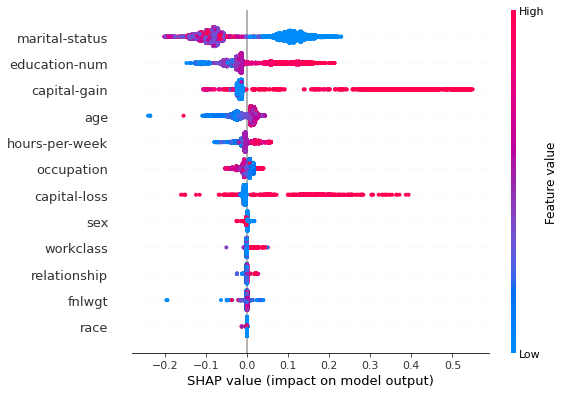

In [88]:
shap.summary_plot(shap_values, X_train)

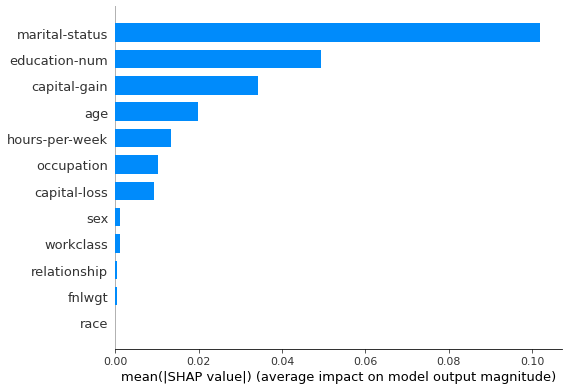

In [84]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [90]:
# shap.dependence_plot("RM", shap_values, X_train, interaction_index='LSTAT')